In [1]:
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
import scipy as sc
import scipy.stats as stats
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm

plt.style.use('fivethirtyeight')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']
cmap_big = cm.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.7, 0.95, 256)))

bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)

Definizione della funzione (sconosciuta) alla base del dataset

In [4]:
def f(x):
    return np.sin(x)*(np.cos(x))**2

Funzione che genera i valori target di un insieme di punti, associando ad un valore $x$ il valore 
$y=f(x)+\varepsilon$, con $\varepsilon$ distribuito secondo una gaussiana di media $0$ e varianza $0.1$ 

In [5]:
def p(r):
    return [stats.norm.rvs(loc=f(x), scale=0.1, size=1) for x in r]

Numero di elementi nel training e nel test set

In [6]:
n_train = 30
n_test = 30

Genera casualmente il training set

In [7]:
x_train = stats.uniform.rvs(size=n_train, loc=-2, scale=4).reshape(-1,1)
y_train = np.array(p(x_train)).reshape(-1,1)

Genera casualmente il test set

In [8]:
x_test = stats.uniform.rvs(size=n_test, loc=-2, scale=4).reshape(-1,1)
y_test = np.array(p(x_test)).reshape(-1,1)

Riporta il plot della funzione e i due dataset

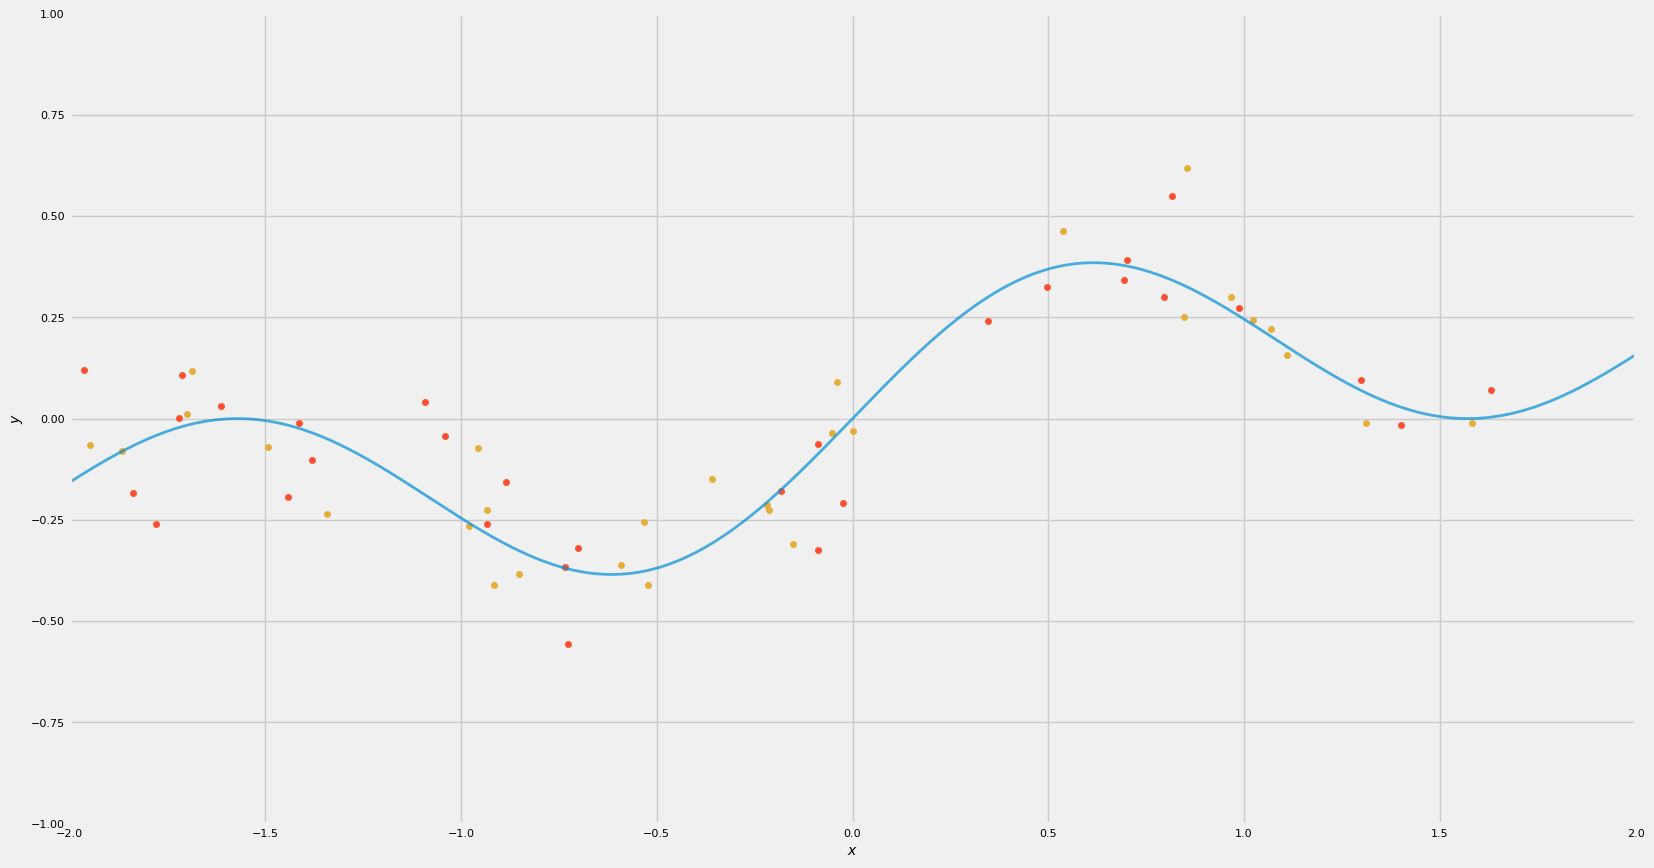

In [9]:
fig, ax = plt.subplots(figsize=(18, 10))
x = np.linspace(-2, 2, 1000)
plt.plot(x, f(x), linewidth=2, alpha = .7)
plt.scatter(x_train, y_train, s=20, color='C1')
plt.scatter(x_test, y_test, s=20, color='C2')
plt.xlim(-2, 2)
plt.ylim(-1,1)
plt.xlabel('$x$')
plt.ylabel(r'$y$')
plt.show()

Funzione che effettua le previsioni di $y$ per tutti gli elementi in $t$ mediante un polinomio i cui coefficienti sono specificati in $\theta$

In [10]:
def predictions(theta, x):
    return np.polyval(theta[::-1],x)

Funzione di costo, definita sul dataset $x,t$ e sul modello rappresentato dai coefficienti $\theta$ del polinomio

In [11]:
def cost(theta, x, t):
    n = x.shape[0]
    y = predictions(theta,x)
    return round(np.sqrt(np.sum((t-y)**2)/float(2*n)), 4)

Grado del polinomio utilizzato:

In [22]:
degree = 5

Calcola matrice delle nuove features corrispondenti ai termini $1, x, x^2, \ldots$

In [23]:
X = np.ones(n_train).reshape(-1,1)
Z = x_train
for i in range(degree):
    X = np.column_stack((X, Z))
    Z = Z*x_train

Calcola vettore con valore ottimo dei coefficienti

In [24]:
theta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y_train)

Calcola costo su train e test set

In [25]:
c_train = cost(theta,x_train,y_train)
c_test = cost(theta,x_test,y_test)

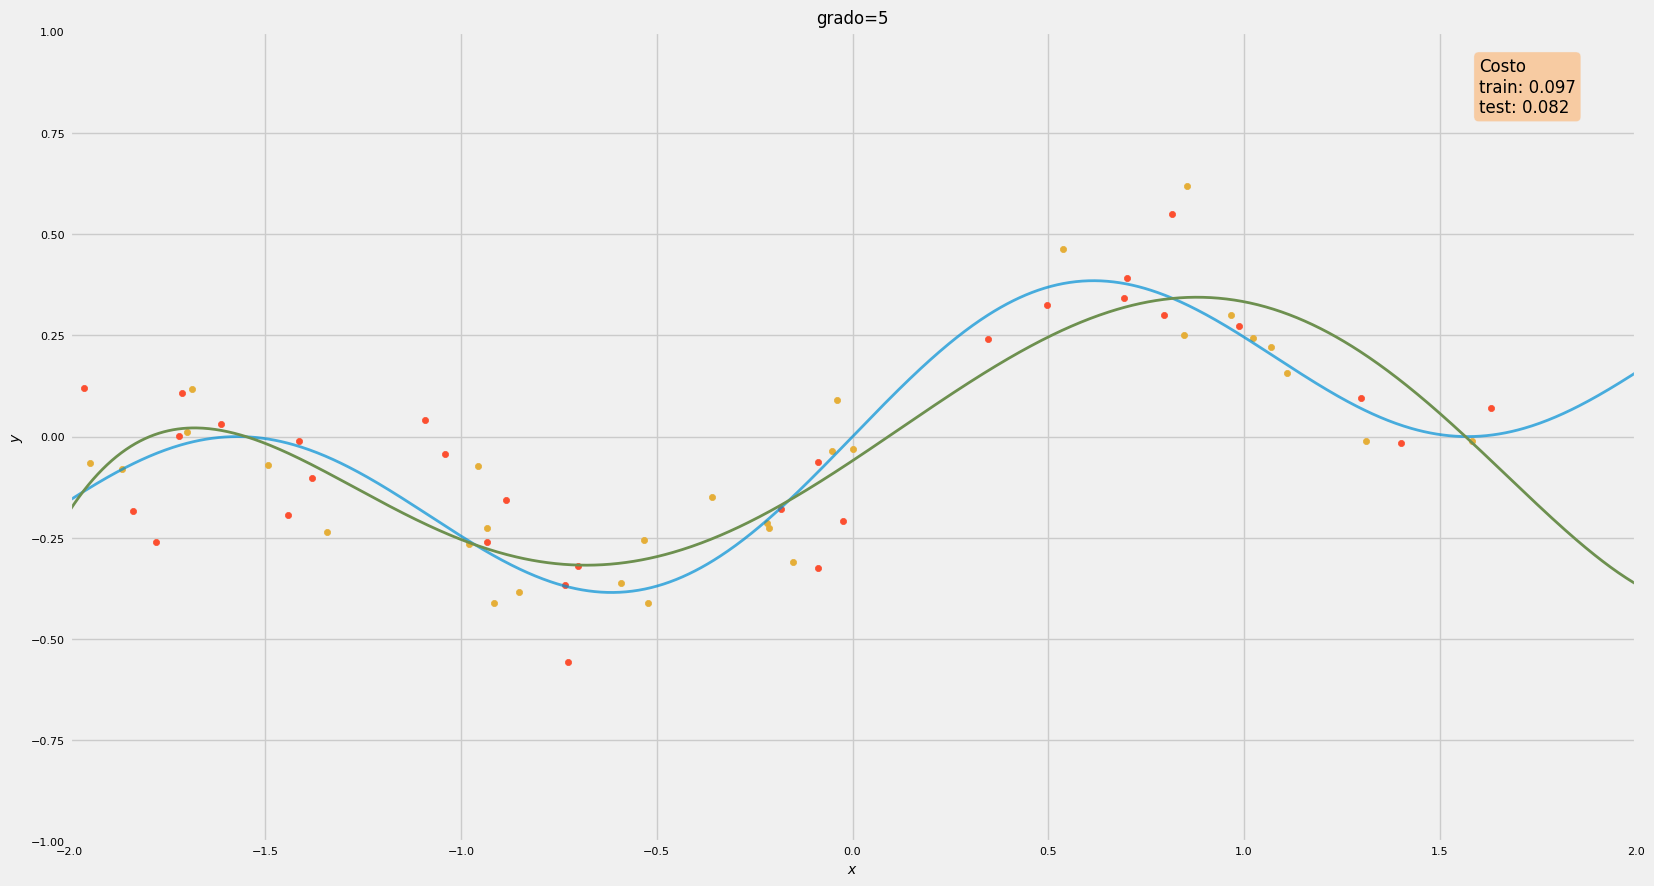

In [26]:
fig, ax = plt.subplots(figsize=(18, 10))
x = np.linspace(-2, 2, 1000)
plt.plot(x, f(x), linewidth=2, alpha = .7)
plt.scatter(x_train, y_train, s=20, color='C1')
plt.scatter(x_test, y_test, s=20, color='C2')
plt.plot(x, predictions(theta,x), color='C3', linewidth=2, alpha=1)
plt.xlim(-2, 2)
plt.ylim(-1,1)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('grado={0:d}'.format(degree), fontsize=12)
plt.text(0.9, 0.9, 'Costo\ntrain: {0:.3f}\ntest: {1:.3f}'.format(c_train, c_test), fontsize=12, 
         transform=ax.transAxes, bbox=bbox_props)
plt.show()

Se consideriamo degree=1 si ottiene una retta, quindi, il miglior predittore di grado 1. 

Se consideriamo degree=5, si ha una curva (verde) che riesce ad approssimare meglio gli elementi rossi. Rispetto al grado 1 le prestazioni sono migliorate sia per il training set che per il testing set. 

Considerare il polinomio di grado 1 rispetto al polinomio di grado 5 ci porta ad una situazione di **underfitting**; la classe è più piccola e ha prestazioni più povere.

Se consideriamo degree=15, la curva (verde) ha un andamento irregolare perchè cerca di prendere al meglio i soli punti rossi e il costo del testing set aumenta. Se si considerano i costi sul training set in realtà non è buono percheè applicandolo ai dati nuovi in realtà poi non si comporterà bene. Si ha una situazione di **overfitting**.

Se consideriamo degree=25, si ha una curva che tende a rappresentare al meglio i dati ma perde di generalità rappresentando male i dati rossi. Il costo del training set diventa molto più grande.

Calcola costo su training e test set al variare del grado del polinomio 

In [27]:
maxdeg = 20
costs_train =  []  
costs_test =  [] 

In [28]:
for degree in range(0, maxdeg):
    X = np.ones(n_train).reshape(-1,1)
    Z = x_train
    for i in range(degree):
        X = np.column_stack((X, Z))
        Z=Z*x_train
    
    theta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y_train)
    
    costs_train.append(cost(theta,x_train,y_train))
    costs_test.append(cost(theta,x_test,y_test))

In [29]:
df = pd.DataFrame()
df['train'] = costs_train
df['test'] = costs_test
df['ratio'] = df.test/df.train
df

,train,test,ratio
0,0.1786,0.1813,1.015118
1,0.1574,0.1578,1.002541
2,0.1503,0.1433,0.953426
3,0.1203,0.1067,0.886949
4,0.1024,0.0960,0.937500
5,0.0970,0.0816,0.841237
6,0.0758,0.0850,1.121372
7,0.0730,0.0886,1.213699
8,0.0730,0.0883,1.209589
9,0.0727,0.0911,1.253095


Il costo del training set tende a diminuire; mentre, sul test set diminuisce inizialmente ma poi risale.

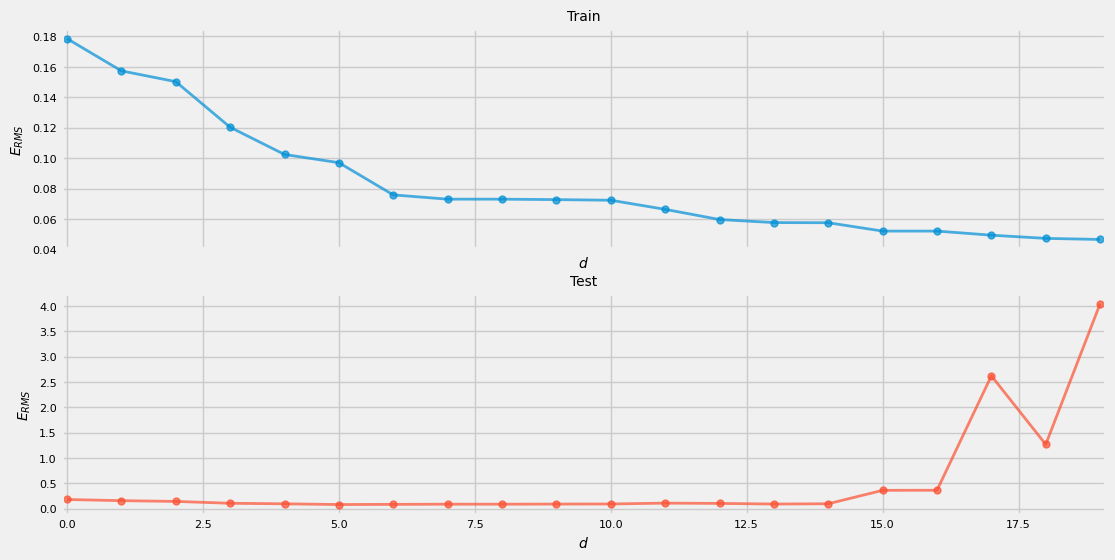

In [30]:
top = maxdeg
fig, axarr = plt.subplots(2, sharex=True, figsize=(12, 6))
axarr[0].plot(df.index[:top], df.train[:top], linewidth=2, alpha = .7, marker = 'o', markersize=5)
axarr[0].set_title('Train')
axarr[0].set_xlabel('$d$')
axarr[0].set_ylabel('$E_{RMS}$')
axarr[1].plot(df.index[:top], df.test[:top], linewidth=2, alpha = .7, marker = 'o', markersize=5, color='C1')
axarr[1].set_title('Test')
plt.xlim(-0.1, df.index[top-1]+.1)
axarr[1].set_xlabel('$d$')
axarr[1].set_ylabel('$E_{RMS}$')
plt.show()

Il costo del training set, come possiamo vedere, diminuisce. Se consideriamo più predittori è facile trovarne uno che rappresenta al meglio il training set. Per esempio, se passiamo dal grado 7 al grado 8 possiamo trovare una curva che va meglio al grado 7. 

*Si cerca un valore del coefficiente che minimizza il rischio empirico*. Se si hanno molti coefficienti è possibile avere predittori molto articolati dato il training set.

Avere tanti coefficienti con un training ste piccolo, il predittore darà valori perfetti. La complessità del modello è considerare quanti coefficienti considerare dato un training set. Se si ha un training set di una certa dimensione non si possono avere predittori di una classe troppo ampia, si andrebbe in **overfitting**.



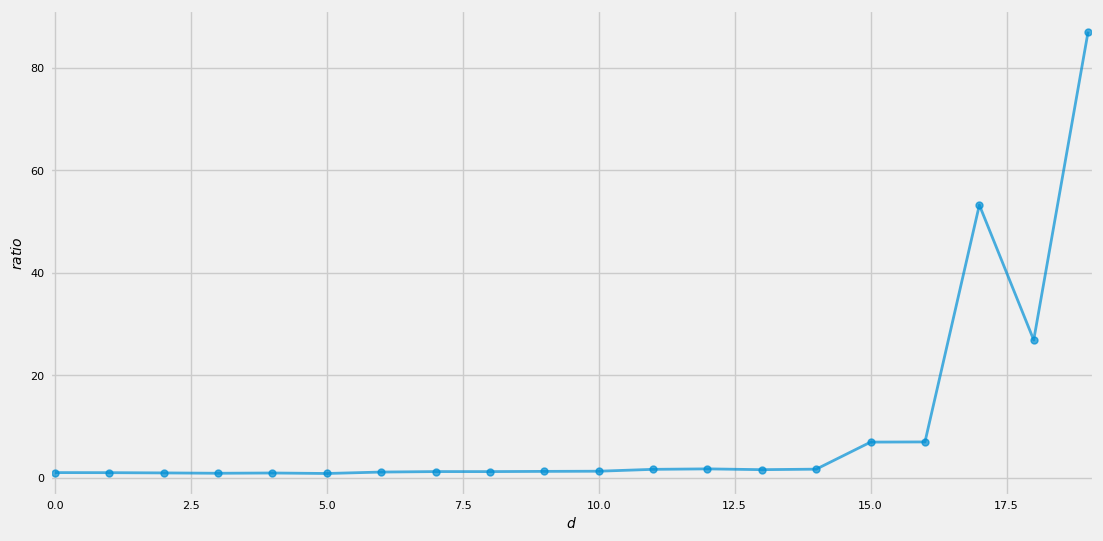

In [31]:
top = maxdeg
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(df.index[:top], df.ratio[:top], linewidth=2, alpha = .7, marker = 'o', markersize=5)
plt.xlim(-0.1, df.index[top-1]+.1)
plt.xlabel('$d$')
plt.ylabel(r'$ratio$')
plt.show()

Questo plot rappresenta il rapporto tra il costo del training set e il tasetin set. Si può notare che tende ad essere piuttosto costante per poi aumentare. 

Avere valori molto bassi all'inizio, vuol dire che il rapporto è molto basso e quindi, i costi del training set e testing set vanno piuttosto male.